In [1]:
import numpy as np
import scipy 
import matplotlib as mlp
import matplotlib.pyplot as plt 


def read(stderr_file):
    with open(stderr_file, "r") as err:
        stderr_content = err.read()
        # 在这里对 stderr_content 进行处理
        sss = stderr_content.split('\n')[3:-2]
        results = {'time': [],'iteration': [],'value': []}
        for line in sss:
            parts = line.strip().split()
            time = float(parts[1])
            iteration = int(parts[-2])
            value = float(parts[-1])
            results['time'].append(time)
            results['iteration'].append(1+iteration)
            results['value'].append(value)
    return results

def draw(p,N):
    result_file = f'./Order_%d/rho_T_1_N_%d.txt'%(p,N)
    rorder_file = f'./logging_Diric4_%d_%d_rel1E3_stdout.txt'%(p,N)
    import os
    if (not os.path.exists(result_file)) \
    or (not os.path.exists(rorder_file)):
        return
    data = np.loadtxt(result_file)
    if len(data) == 0 or len(np.loadtxt(rorder_file))==0:
        return 
    x,y,z, rh,rs, uh,us, vh,vs, wh,ws, eh,es = data.T

    plt.figure(figsize=(7,3.2),dpi=200)

    plt.subplot(1,2,1)
    plt.tripcolor(x,y,eh,cmap='jet')
    plt.colorbar()
    plt.xticks(np.linspace(0,1,6))
    plt.yticks(np.linspace(0,1,6))
    plt.xticks(np.linspace(0,1,11),minor=True)
    plt.yticks(np.linspace(0,1,11),minor=True)
    plt.grid(which='both')
    plt.title(r'$E_h(t=\infty)$')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')

    plt.subplot(1,2,2)
    plt.tripcolor(x,y,eh-es,cmap='jet')
    plt.colorbar()
    plt.xticks(np.linspace(0,1,6))
    plt.yticks(np.linspace(0,1,6))
    plt.xticks(np.linspace(0,1,11),minor=True)
    plt.yticks(np.linspace(0,1,11),minor=True)
    plt.grid(which='both')
    plt.title(r'$E_h(t=\infty)-E(t=\infty)$')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    
    plt.suptitle(r'Error of Energy, $\|E_h-E\|/\|E\|$=%.2e'%(
    np.loadtxt(rorder_file)[5]))
    plt.tight_layout()
    plt.show()
    

In [8]:
!g++ ../PoiseuilleBatch3.cpp -o PoiseuilleBatch3 -fopenmp -mfma -mavx2 -O3 -g -I../
# -march=skylake -mtune=skylake -flto=8 -fomit-frame-pointer -funroll-loops -fno-math-errno -ffast-math 


Time variable                                   usr           sys          wall           GGC
 phase setup                        :   0.01 (  0%)   0.00 (  0%)   0.01 (  0%)  1915k (  0%)
 phase parsing                      :   9.86 ( 14%)   3.77 ( 35%)  13.64 ( 17%)   445M ( 24%)
 phase lang. deferred               :  10.14 ( 15%)   2.40 ( 23%)  12.53 ( 16%)   479M ( 26%)
 phase opt and generate             :  47.37 ( 69%)   4.26 ( 40%)  51.64 ( 65%)   886M ( 48%)
 phase last asm                     :   1.59 (  2%)   0.18 (  2%)   1.77 (  2%)    37M (  2%)
 phase finalize                     :   0.00 (  0%)   0.01 (  0%)   0.01 (  0%)     0  (  0%)
 |name lookup                       :   3.23 (  5%)   0.90 (  8%)   4.16 (  5%)    22M (  1%)
 |overload resolution               :   6.26 (  9%)   1.48 ( 14%)   7.58 ( 10%)   271M ( 15%)
 garbage collection                 :   1.97 (  3%)   0.00 (  0%)   1.98 (  2%)     0  (  0%)
 dump files                         :   0.43 (  1%)   0.15 

In [56]:
# !./PoiseuilleBatch3 1 3

In [57]:
import subprocess
import time

start = time.time()
p_list = [1]
N_list = [3,4,5,6,8,10,12,16,20]
left = 0
right = len(N_list)
p = 1
for k,N in enumerate(N_list[left:right]):
    # 定义输出文件路径
    stdout_file = f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt"
    stderr_file = f"./logging_Diric4_{p}_{N}_rel1E4_stderr.txt"

    # 构造命令
    command = f"./PoiseuilleBatch3 {p} {N}"

    # 执行命令并捕获输出
    with open(stdout_file, "w") as out, open(stderr_file, "w") as err:
        process = subprocess.Popen(command, shell=True, stdout=out, stderr=err)
        process.wait()  # 等待进程完成


    draw(p,N)
    result = {}
    NN = []
    EE = []
    for N in N_list[:(left+k+1)]:
        # result[N] = read(stderr_file)
        NN.append(N)
        EE.append(np.loadtxt(f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt")[5])
    print(time.time()-start,NN,EE)
    if(len(NN)>1):
        print(np.diff(np.log(np.array(EE)))/np.diff(np.log(np.array(NN))))

    # plt.figure(figsize=(7,3.2),dpi=200)
    # plt.subplot(1,2,1)
    # for N,V in result.items():
    #     l1 = plt.loglog(V['iteration'][0::2],V['value'][0::2],'-',label=r'p=%d, N=%d'%(p,N))
    #     # l2 = plt.loglog(V['iteration'][1::2],V['value'][1::2],'--',label=r'p=%d, N=%d, $\|\Delta\mathbf{U}\|$'%(p,N),c=l1[0].get_color(),alpha=0.25)
    # plt.xlabel(r'# of iteration')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.subplot(1,2,2)
    # for N,V in result.items():
    #     plt.loglog(V['time'][0::2],V['value'][0::2],label=r'p=%d, N=%d'%(p,N))
    # plt.xlabel(r'time / second')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

3.878999948501587 [3] [0.000203707]
12.206501960754395 [3, 4] [0.000203707, 0.000117204]
[-1.92144987]
24.876981735229492 [3, 4, 5] [0.000203707, 0.000117204, 7.56819e-05]
[-1.92144987 -1.96006998]
44.674670457839966 [3, 4, 5, 6] [0.000203707, 0.000117204, 7.56819e-05, 5.24721e-05]
[-1.92144987 -1.96006998 -2.00885423]
95.24370956420898 [3, 4, 5, 6, 8] [0.000203707, 0.000117204, 7.56819e-05, 5.24721e-05, 2.90992e-05]
[-1.92144987 -1.96006998 -2.00885423 -2.04938359]
258.8906831741333 [3, 4, 5, 6, 8, 10] [0.000203707, 0.000117204, 7.56819e-05, 5.24721e-05, 2.90992e-05, 1.83276e-05]
[-1.92144987 -1.96006998 -2.00885423 -2.04938359 -2.071772  ]
622.0652809143066 [3, 4, 5, 6, 8, 10, 12] [0.000203707, 0.000117204, 7.56819e-05, 5.24721e-05, 2.90992e-05, 1.83276e-05, 1.25497e-05]
[-1.92144987 -1.96006998 -2.00885423 -2.04938359 -2.071772   -2.07716173]


KeyboardInterrupt: 

In [59]:
import subprocess
import time

start = time.time()

N_list = [3,4,5,6,8,10,12,16,20]
left = 0
right = len(N_list)
p = 2
for k,N in enumerate(N_list[left:right]):
    # 定义输出文件路径
    stdout_file = f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt"
    stderr_file = f"./logging_Diric4_{p}_{N}_rel1E4_stderr.txt"

    # 构造命令
    command = f"./PoiseuilleBatch3 {p} {N}"

    # 执行命令并捕获输出
    with open(stdout_file, "w") as out, open(stderr_file, "w") as err:
        process = subprocess.Popen(command, shell=True, stdout=out, stderr=err)
        process.wait()  # 等待进程完成


    draw(p,N)
    result = {}
    NN = []
    EE = []
    for N in N_list[:(left+k+1)]:
        # result[N] = read(stderr_file)
        NN.append(N)
        EE.append(np.loadtxt(f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt")[5])
    print(time.time()-start,NN,EE)
    if(len(NN)>1):
        print(np.diff(np.log(np.array(EE)))/np.diff(np.log(np.array(NN))))

    # plt.figure(figsize=(7,3.2),dpi=200)
    # plt.subplot(1,2,1)
    # for N,V in result.items():
    #     l1 = plt.loglog(V['iteration'][0::2],V['value'][0::2],'-',label=r'p=%d, N=%d'%(p,N))
    #     # l2 = plt.loglog(V['iteration'][1::2],V['value'][1::2],'--',label=r'p=%d, N=%d, $\|\Delta\mathbf{U}\|$'%(p,N),c=l1[0].get_color(),alpha=0.25)
    # plt.xlabel(r'# of iteration')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.subplot(1,2,2)
    # for N,V in result.items():
    #     plt.loglog(V['time'][0::2],V['value'][0::2],label=r'p=%d, N=%d'%(p,N))
    # plt.xlabel(r'time / second')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

53.783576011657715 [3] [3.58139e-05]
154.08750748634338 [3, 4] [3.58139e-05, 1.64062e-05]
[-2.71367891]
291.05873227119446 [3, 4, 5] [3.58139e-05, 1.64062e-05, 8.76489e-06]
[-2.71367891 -2.80942622]
518.7639656066895 [3, 4, 5, 6] [3.58139e-05, 1.64062e-05, 8.76489e-06, 5.20551e-06]
[-2.71367891 -2.80942622 -2.85778762]
1100.993662595749 [3, 4, 5, 6, 8] [3.58139e-05, 1.64062e-05, 8.76489e-06, 5.20551e-06, 2.2651e-06]
[-2.71367891 -2.80942622 -2.85778762 -2.89242484]
2554.5368223190308 [3, 4, 5, 6, 8, 10] [3.58139e-05, 1.64062e-05, 8.76489e-06, 5.20551e-06, 2.2651e-06, 1.18212e-06]
[-2.71367891 -2.80942622 -2.85778762 -2.89242484 -2.91430995]


KeyboardInterrupt: 

In [60]:
import subprocess
import time

start = time.time()

N_list = [3,4,5,6,8,10,12,16,20]
left = 0
right = len(N_list)
p = 3
for k,N in enumerate(N_list[left:right]):
    # 定义输出文件路径
    stdout_file = f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt"
    stderr_file = f"./logging_Diric4_{p}_{N}_rel1E4_stderr.txt"

    # 构造命令
    command = f"./PoiseuilleBatch3 {p} {N}"

    # 执行命令并捕获输出
    with open(stdout_file, "w") as out, open(stderr_file, "w") as err:
        process = subprocess.Popen(command, shell=True, stdout=out, stderr=err)
        process.wait()  # 等待进程完成


    draw(p,N)
    result = {}
    NN = []
    EE = []
    for N in N_list[:(left+k+1)]:
        # result[N] = read(stderr_file)
        NN.append(N)
        EE.append(np.loadtxt(f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt")[5])
    print(time.time()-start,NN,EE)
    if(len(NN)>1):
        print(np.diff(np.log(np.array(EE)))/np.diff(np.log(np.array(NN))))

    # plt.figure(figsize=(7,3.2),dpi=200)
    # plt.subplot(1,2,1)
    # for N,V in result.items():
    #     l1 = plt.loglog(V['iteration'][0::2],V['value'][0::2],'-',label=r'p=%d, N=%d'%(p,N))
    #     # l2 = plt.loglog(V['iteration'][1::2],V['value'][1::2],'--',label=r'p=%d, N=%d, $\|\Delta\mathbf{U}\|$'%(p,N),c=l1[0].get_color(),alpha=0.25)
    # plt.xlabel(r'# of iteration')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.subplot(1,2,2)
    # for N,V in result.items():
    #     plt.loglog(V['time'][0::2],V['value'][0::2],label=r'p=%d, N=%d'%(p,N))
    # plt.xlabel(r'time / second')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

234.2922089099884 [3] [2.70044e-06]
686.1792182922363 [3, 4] [2.70044e-06, 8.64685e-07]
[-3.95855297]
1503.7674639225006 [3, 4, 5] [2.70044e-06, 8.64685e-07, 3.54903e-07]
[-3.95855297 -3.99079768]
2999.130828142166 [3, 4, 5, 6] [2.70044e-06, 8.64685e-07, 3.54903e-07, 1.71209e-07]
[-3.95855297 -3.99079768 -3.99820785]


KeyboardInterrupt: 

In [61]:
import subprocess
import time

start = time.time()

N_list = [3,4,5,6,8,10,12,16,20]
left = 0
right = len(N_list)
p = 4
for k,N in enumerate(N_list[left:right]):
    # 定义输出文件路径
    stdout_file = f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt"
    stderr_file = f"./logging_Diric4_{p}_{N}_rel1E4_stderr.txt"

    # 构造命令
    command = f"./PoiseuilleBatch3 {p} {N}"

    # 执行命令并捕获输出
    with open(stdout_file, "w") as out, open(stderr_file, "w") as err:
        process = subprocess.Popen(command, shell=True, stdout=out, stderr=err)
        process.wait()  # 等待进程完成


    draw(p,N)
    result = {}
    NN = []
    EE = []
    for N in N_list[:(left+k+1)]:
        # result[N] = read(stderr_file)
        NN.append(N)
        EE.append(np.loadtxt(f"./logging_Diric4_{p}_{N}_rel1E4_stdout.txt")[5])
    print(time.time()-start,NN,EE)
    if(len(NN)>1):
        print(np.diff(np.log(np.array(EE)))/np.diff(np.log(np.array(NN))))

    # plt.figure(figsize=(7,3.2),dpi=200)
    # plt.subplot(1,2,1)
    # for N,V in result.items():
    #     l1 = plt.loglog(V['iteration'][0::2],V['value'][0::2],'-',label=r'p=%d, N=%d'%(p,N))
    #     # l2 = plt.loglog(V['iteration'][1::2],V['value'][1::2],'--',label=r'p=%d, N=%d, $\|\Delta\mathbf{U}\|$'%(p,N),c=l1[0].get_color(),alpha=0.25)
    # plt.xlabel(r'# of iteration')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.subplot(1,2,2)
    # for N,V in result.items():
    #     plt.loglog(V['time'][0::2],V['value'][0::2],label=r'p=%d, N=%d'%(p,N))
    # plt.xlabel(r'time / second')
    # plt.ylabel(r'$\|F(\mathbf{U})\|$')
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

KeyboardInterrupt: 

/tmp/ipykernel_1923/1291553395.py:16: UserWarning: loadtxt: input contained no data: "./logging_Diric4_1_6_rel1E4_stdout.txt"
  data = np.loadtxt(filename)
/tmp/ipykernel_1923/1291553395.py:16: UserWarning: loadtxt: input contained no data: "./logging_Diric4_1_16_rel1E4_stdout.txt"
  data = np.loadtxt(filename)
/tmp/ipykernel_1923/1291553395.py:16: UserWarning: loadtxt: input contained no data: "./logging_Diric4_2_12_rel1E4_stdout.txt"
  data = np.loadtxt(filename)
/tmp/ipykernel_1923/1291553395.py:16: UserWarning: loadtxt: input contained no data: "./logging_Diric4_3_8_rel1E4_stdout.txt"
  data = np.loadtxt(filename)


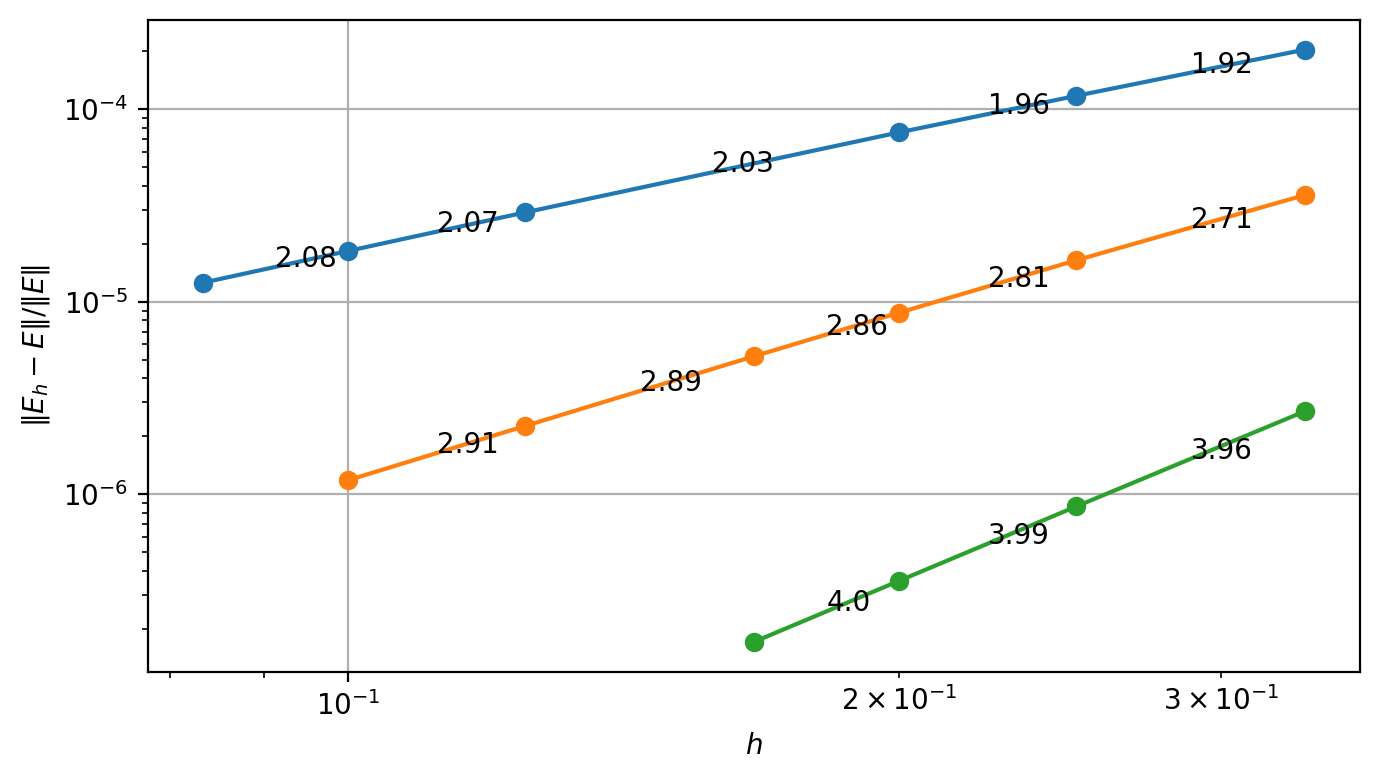

In [9]:
import numpy as np
import scipy 
import matplotlib as mlp
import matplotlib.pyplot as plt 
import os


plt.figure(figsize=(7,4),dpi=200)
for p in range(3):
    p = p+1
    NN = []
    EE = []
    for N in range(30):
        filename = f'./logging_Diric4_{p}_{N}_rel1E4_stdout.txt'
        if not os.path.exists(filename): continue
        data = np.loadtxt(filename)
        if(len(data)==0): continue
        err = data[5]
        NN.append(N)
        EE.append(err)
    h = 1/np.array(NN)
    error = np.array(EE)
    order = np.diff(np.log(error))/np.diff(np.log(h))
    plt.loglog(h,error,'o-',label='p=%d'%(p))
    gm = lambda x: (x[1:]*x[:-1])**0.5
    for x,y,o in zip(gm(h),gm(error),order):
        plt.text(x,y,o.round(2))
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$\|E_h-E\|/\|E\|$')
plt.tight_layout()
plt.show()

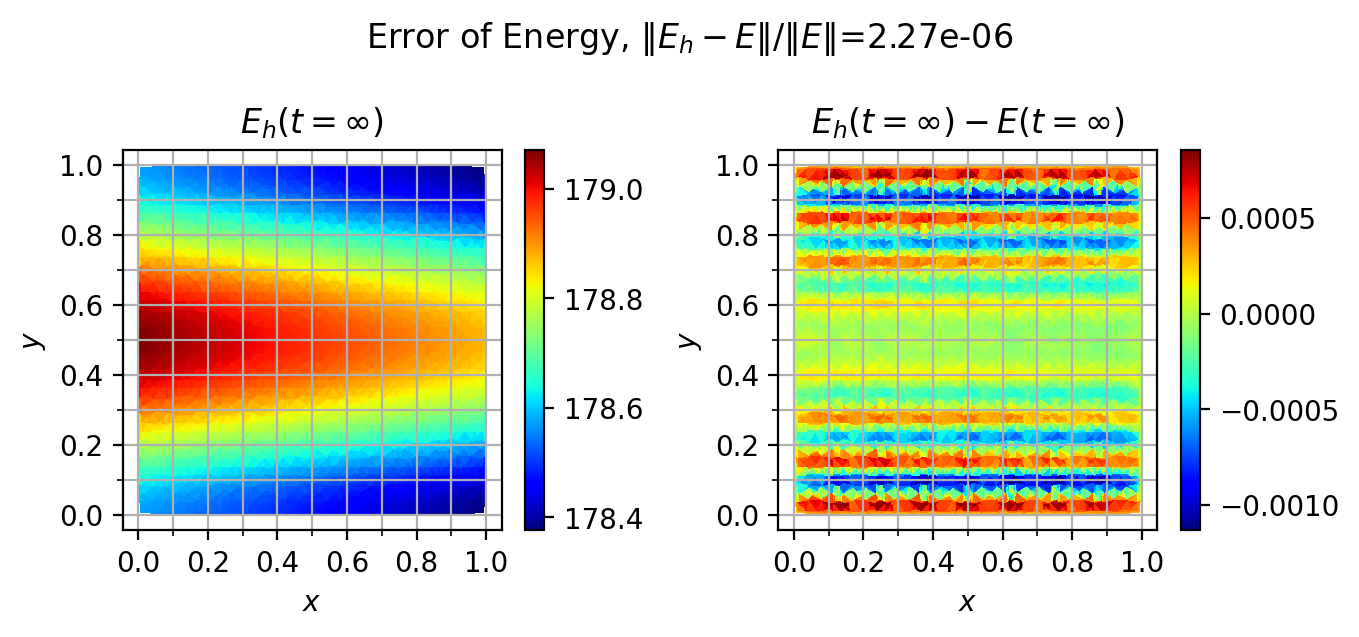

In [14]:
p = 2
N = 8
result_file = f'./Order_%d/rho_T_1_N_%d.txt'%(p,N)
rorder_file = f'./logging_Diric4_%d_%d_rel1E4_stdout.txt'%(p,N)
data = np.loadtxt(result_file)
x,y,z, rh,rs, uh,us, vh,vs, wh,ws, eh,es = data.T

plt.figure(figsize=(7,3.2),dpi=200)

plt.subplot(1,2,1)
plt.tripcolor(x,y,eh,cmap='jet')
plt.colorbar()
plt.xticks(np.linspace(0,1,6))
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,1,11),minor=True)
plt.yticks(np.linspace(0,1,11),minor=True)
plt.grid(which='both')
plt.title(r'$E_h(t=\infty)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.subplot(1,2,2)
plt.tripcolor(x,y,eh-es,cmap='jet')
plt.colorbar()
plt.xticks(np.linspace(0,1,6))
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,1,11),minor=True)
plt.yticks(np.linspace(0,1,11),minor=True)
plt.grid(which='both')
plt.title(r'$E_h(t=\infty)-E(t=\infty)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.suptitle(r'Error of Energy, $\|E_h-E\|/\|E\|$=%.2e'%(
np.loadtxt(rorder_file)[5]))
plt.tight_layout()
plt.show()